<a href="https://colab.research.google.com/github/simotogn/Phase-Contrast-Computer-Tomography-/blob/main/ct_astra_shepplogan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install astra-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cufft-cu12
    Found existing installation: nvidia-cufft-cu12 11.3.0.4
    Uninstalling nvidia-cufft-cu12-11.3.0.4:
      Successfully uninstalled nvidia-cufft-cu12-11.3.0.4
  Attempting uninstall: nvidia-cuda-runtime-cu12
    Found existing installation: nvidia-cuda-runtime-cu12 12.6.77
    Uninstalling nvidia-cuda-runtime-cu12-12.6.77:
      Successfully uninstalled nvidia-cuda-runtime-cu12-12.6.77
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires nvidia-cuda-runtime-cu12==12.6.77; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-ru

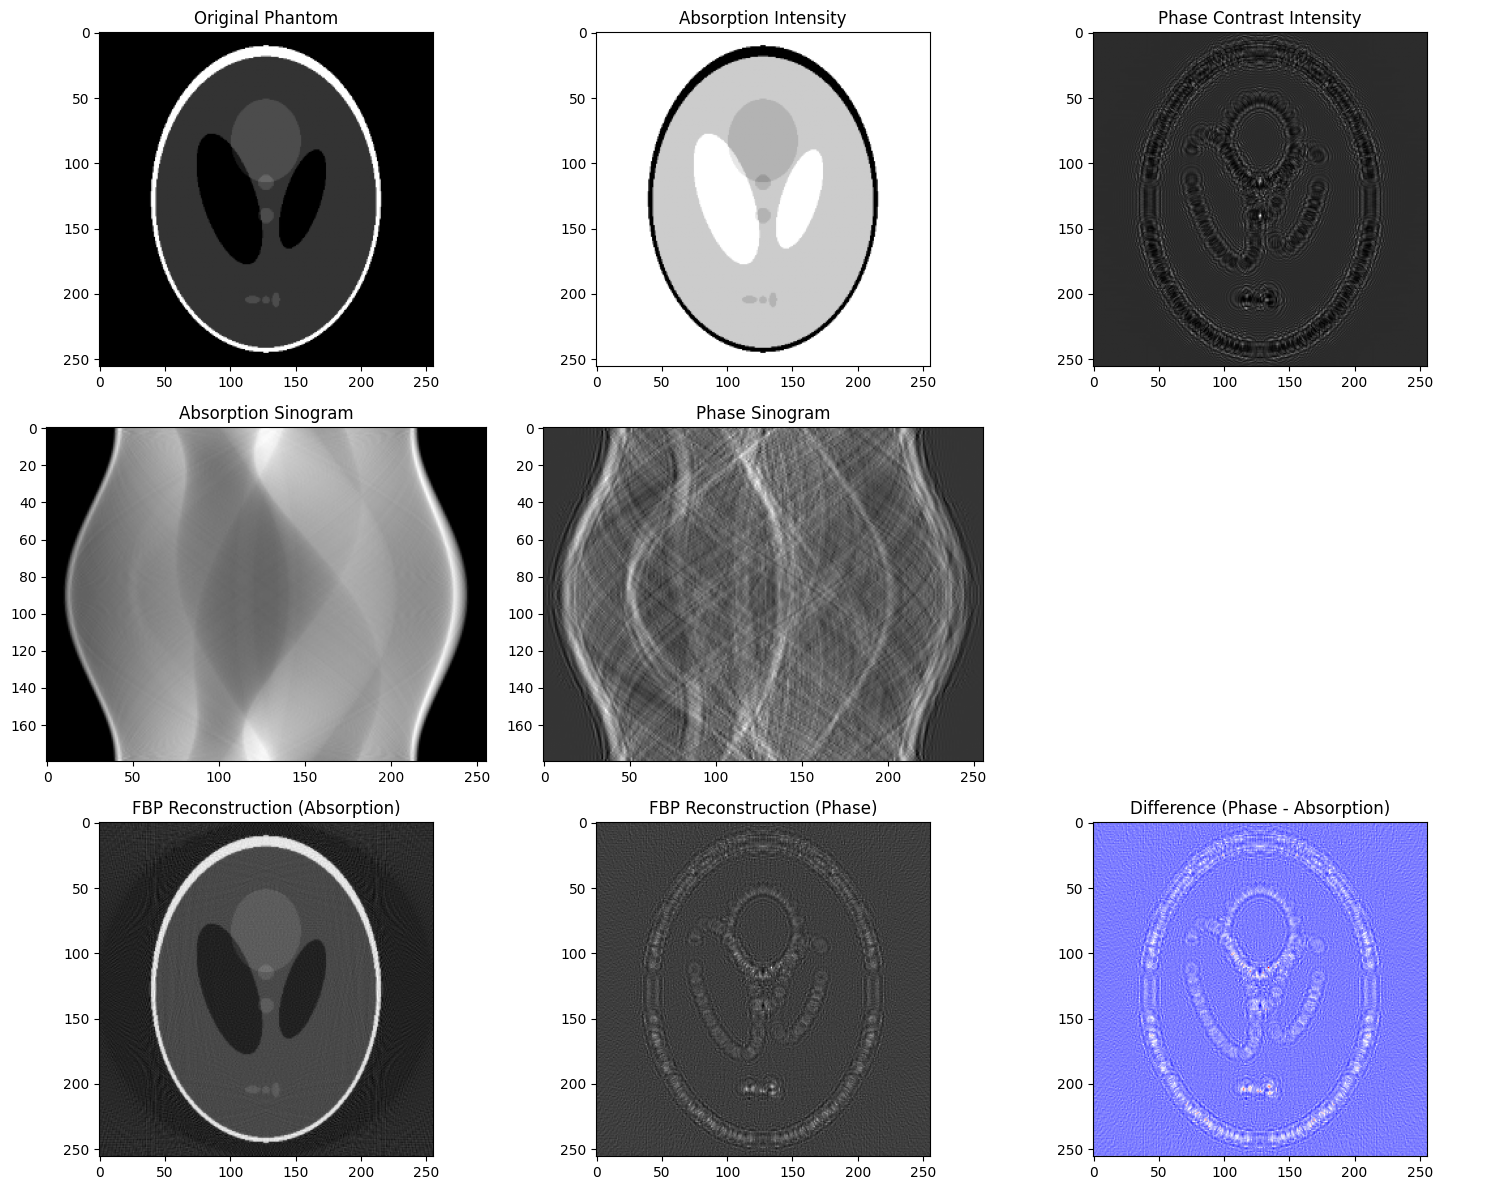

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astra
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from scipy.fft import fft2, ifft2, fftfreq
from scipy.ndimage import gaussian_filter

# === PARAMETERS ===
N = 256
pixel_size = 1e-6
wavelength = 0.05e-9
z = 0.5
delta = 5e-5
beta = 1e-9
t = 50e-6

# === CREATE SHEPP-LOGAN PHANTOM ===
phantom = shepp_logan_phantom()
image = resize(phantom, (N, N), mode='reflect', anti_aliasing=True)
image = (image - image.min()) / (image.max() - image.min())

# === TRANSMISSION AND PROPAGATION ===
k = 2 * np.pi / wavelength
transmission = np.exp(-k * beta * t * image) * np.exp(1j * k * delta * t * image)
I_abs = np.abs(transmission)**2

# Fourier propagation
fx = fftfreq(N, pixel_size)
fy = fftfreq(N, pixel_size)
FX, FY = np.meshgrid(fx, fy)
arg = 1.0 - (wavelength * FX)**2 - (wavelength * FY)**2
sqrt_term = np.sqrt(np.clip(arg, 0.0, None))
H = np.exp(1j * 2 * np.pi * z / wavelength * sqrt_term)
wave = ifft2(fft2(transmission) * H)
I_phase = np.abs(wave)**2


# Create volume geometry
vol_geom = astra.create_vol_geom(N, N)

# Create projection geometry - parallel beam
angles = np.linspace(0, np.pi, 180, endpoint=False)
proj_geom = astra.create_proj_geom('parallel', 1.0, N, angles)

# Absorption sinogram
projector_id = astra.create_projector('line', proj_geom, vol_geom)
sinogram_abs_id, sinogram_abs = astra.create_sino(-np.log(np.clip(I_abs, 1e-12, None)), projector_id)

# Phase contrast sinogram with Paganin retrieval
def paganin_phase_retrieval(I, delta_over_beta, z, wavelength, dx):
    Nx, Ny = I.shape
    fx = fftfreq(Nx, dx)
    fy = fftfreq(Ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    H = 1.0 / (1.0 + (wavelength * z / (4*np.pi*delta_over_beta)) * (FX**2 + FY**2))

    I_log = -np.log(np.clip(I, 1e-12, None))
    I_fft = fft2(I_log)
    phi_retrieved = np.real(ifft2(I_fft * H))
    return phi_retrieved

delta_over_beta = delta / beta
proj_phase = paganin_phase_retrieval(I_phase, delta_over_beta, z, wavelength, pixel_size)
sinogram_phase_id, sinogram_phase = astra.create_sino(proj_phase, projector_id)

# Reconstruction for absorption
rec_abs_id = astra.data2d.create('-vol', vol_geom)
cfg_abs = astra.astra_dict('FBP')
cfg_abs['ProjectionDataId'] = sinogram_abs_id
cfg_abs['ReconstructionDataId'] = rec_abs_id
cfg_abs['ProjectorId'] = projector_id
alg_abs_id = astra.algorithm.create(cfg_abs)
astra.algorithm.run(alg_abs_id)
rec_abs = astra.data2d.get(rec_abs_id)

# Reconstruction for phase contrast
rec_phase_id = astra.data2d.create('-vol', vol_geom)
cfg_phase = astra.astra_dict('FBP')
cfg_phase['ProjectionDataId'] = sinogram_phase_id
cfg_phase['ReconstructionDataId'] = rec_phase_id
cfg_phase['ProjectorId'] = projector_id
alg_phase_id = astra.algorithm.create(cfg_phase)
astra.algorithm.run(alg_phase_id)
rec_phase = astra.data2d.get(rec_phase_id)

# === VISUALIZATION ===
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Original images
axes[0,0].imshow(image, cmap='gray')
axes[0,0].set_title("Original Phantom")
axes[0,1].imshow(I_abs, cmap='gray')
axes[0,1].set_title("Absorption Intensity")
axes[0,2].imshow(I_phase, cmap='gray')
axes[0,2].set_title("Phase Contrast Intensity")

# Sinograms
axes[1,0].imshow(sinogram_abs, cmap='gray', aspect='auto')
axes[1,0].set_title("Absorption Sinogram")
axes[1,1].imshow(sinogram_phase, cmap='gray', aspect='auto')
axes[1,1].set_title("Phase Sinogram")
axes[1,2].axis('off')

# Reconstructions
axes[2,0].imshow(rec_abs, cmap='gray')
axes[2,0].set_title("FBP Reconstruction (Absorption)")
axes[2,1].imshow(rec_phase, cmap='gray')
axes[2,1].set_title("FBP Reconstruction (Phase)")
axes[2,2].imshow(rec_phase - rec_abs, cmap='bwr')
axes[2,2].set_title("Difference (Phase - Absorption)")

plt.tight_layout()
plt.show()

# === CLEANUP ===
astra.algorithm.delete(alg_abs_id)
astra.algorithm.delete(alg_phase_id)
astra.data2d.delete(rec_abs_id)
astra.data2d.delete(rec_phase_id)
astra.data2d.delete(sinogram_abs_id)
astra.data2d.delete(sinogram_phase_id)
astra.projector.delete(projector_id)

